# [단기강좌 실습] Facies classification using Machine Learning

강사: 윤대웅 (전남대학교)

본 실습 코드는 2016년 SEG에서 주최한 Machine Learning Contest by Brendon Hall and Matt Hall 문제를 다룬다 (https://github.com/seg/2016-ml-contest). <br>
ML Contest by Hall은 머신러닝을 이용하여 암상 분류가 완료된 다수의 물리검층 자료를 학습시킨 후, 새로운 물리검층 자료에서 암상을 예측하는 문제이다(Hall, 2016). <br>

본 코드에서는 수동으로 모델을 학습하는 방법, 무작위 탐색법, 베이지안 최적화법, Hyperopt-Sklearn을 이용한 자동학습법(AutoML) 등을 이용하여 지도학습기반 머신러닝 기법을 암상분류 문제에 적용해본다. <br>

**Content** <br>
1. Take a quick look at the data structure
2. Data Preprocessing <br>
2.1. Handling missing data  <br>
2.2. Feature augmentation<br>
2.3. Scaling<br>
3. Manual Search
4. Random Search with CV
5. Bayesian Optimization with CV
6. Hyperopt-Sklearn


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
import numpy as np
from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings("ignore")

# 1. Take a quick look at the data structure

In [2]:
training_data = pd.read_csv('training_data.csv')
test_data = pd.read_csv('test_data.csv')

In [3]:
training_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,2,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,2,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979
2,2,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957
3,2,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936
4,2,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...,...,...,...,...
4144,4,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685
4145,4,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677
4146,4,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669
4147,4,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661


In [4]:
training_data['Well Name'].unique()

array(['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A',
       'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY',
       'CHURCHMAN BIBLE'], dtype=object)

In [5]:
test_data

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.300,10.650,3.591,1,1.000,2
1,A1 SH,STUART,2808.5,77.252,0.585,6.500,11.950,3.341,1,0.978,2
2,A1 SH,STUART,2809.0,82.899,0.566,9.400,13.600,3.064,1,0.956,2
3,A1 SH,STUART,2809.5,80.671,0.593,9.500,13.250,2.977,1,0.933,2
4,A1 SH,STUART,2810.0,75.971,0.638,8.700,12.350,3.020,1,0.911,2
...,...,...,...,...,...,...,...,...,...,...,...
795,C SH,CRAWFORD,3158.5,86.078,0.554,5.040,16.150,3.161,1,0.639,1
796,C SH,CRAWFORD,3159.0,88.855,0.539,5.560,16.750,3.118,1,0.611,1
797,C SH,CRAWFORD,3159.5,90.490,0.530,6.360,16.780,3.168,1,0.583,1
798,C SH,CRAWFORD,3160.0,90.975,0.522,7.035,16.995,3.154,1,0.556,1


In [6]:
test_data['Well Name'].unique()

array(['STUART', 'CRAWFORD'], dtype=object)

총 7개의 feature로 구성:<br>
* GR - gamma ray
* ILD_log10 - resistivity logging
* PE - photoelectric effect
* DeltaPHI - neutron-density porosity difference 
* PHIND - average neutron-density porosity
* NM_M - nonmarine/marine indicator
* RELPOS - relative position

총 9개의 facies(classes of rocks):
0. Nonmarine sandstone
1. Nonmarine coarse siltstone 
2. Nonmarine fine siltstone 
3. Marine siltstone and shale 
4. Mudstone (limestone)
5. Wackestone (limestone)
6. Dolomite
7. Packstone-grainstone (limestone)
8. Phylloid-algal bafflestone (limestone)


Adjacent Facies 정보:

Facies |Label| Adjacent Facies
:---: | :---: |:--:
0 |Nonmarine sandstone(SS)| 2
1 |Nonmarine coarse siltstone(CSiS)| 1,3
2 |Nonmarine fine siltstone(FSiS)| 2
3 |Marine siltstone and shale(SiSh)| 5
4 |Mudstone(MS)| 4,6
5 |Wackestone(WS)| 5,7
6 |Dolomite(D)| 6,8
7 |Packstone-grainstone(PS)| 6,7,9
8 |Phylloid-algal bafflestone(BS)| 7,8


In [7]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     4149 non-null   int64  
 1   Formation  4149 non-null   object 
 2   Well Name  4149 non-null   object 
 3   Depth      4149 non-null   float64
 4   GR         4149 non-null   float64
 5   ILD_log10  4149 non-null   float64
 6   DeltaPHI   4149 non-null   float64
 7   PHIND      4149 non-null   float64
 8   PE         3232 non-null   float64
 9   NM_M       4149 non-null   int64  
 10  RELPOS     4149 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 356.7+ KB


In [8]:
training_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,3232.000000,4149.000000,4149.000000
mean,3.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.896152,0.499720,0.286644
min,0.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,1.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.100000,1.000000,0.277000
50%,3.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.551500,2.000000,0.528000
75%,5.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.300000,2.000000,0.769000
max,8.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


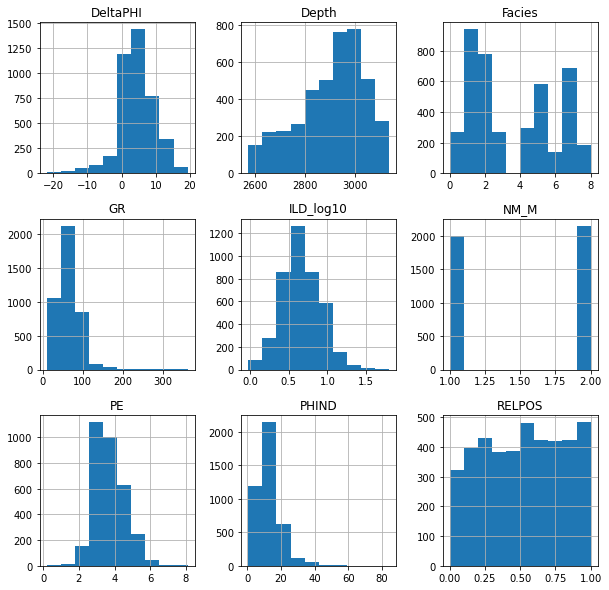

In [9]:
training_data.hist(figsize=(10,10))
plt.show()

In [10]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies']]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

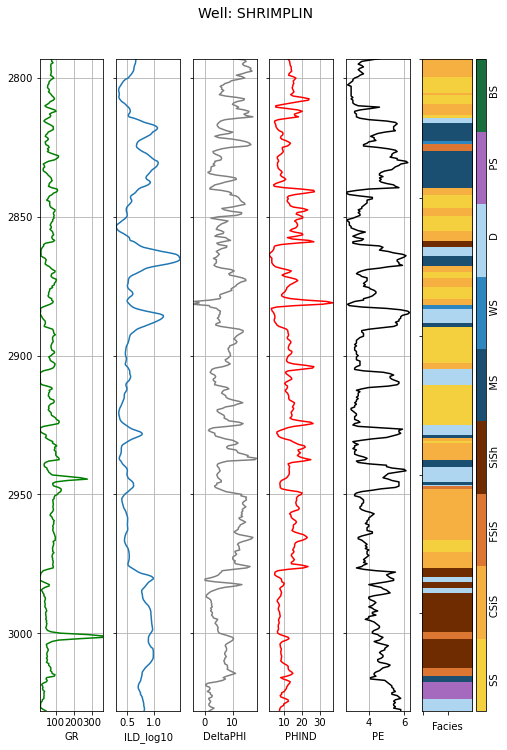

In [11]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

SS      268
CSiS    940
FSiS    780
SiSh    271
MS      296
WS      582
D       141
PS      686
BS      185
Name: Facies, dtype: int64

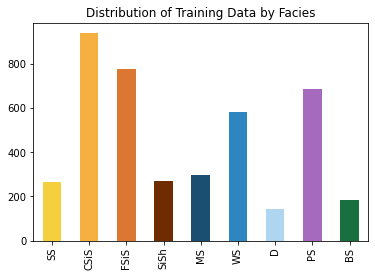

In [12]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

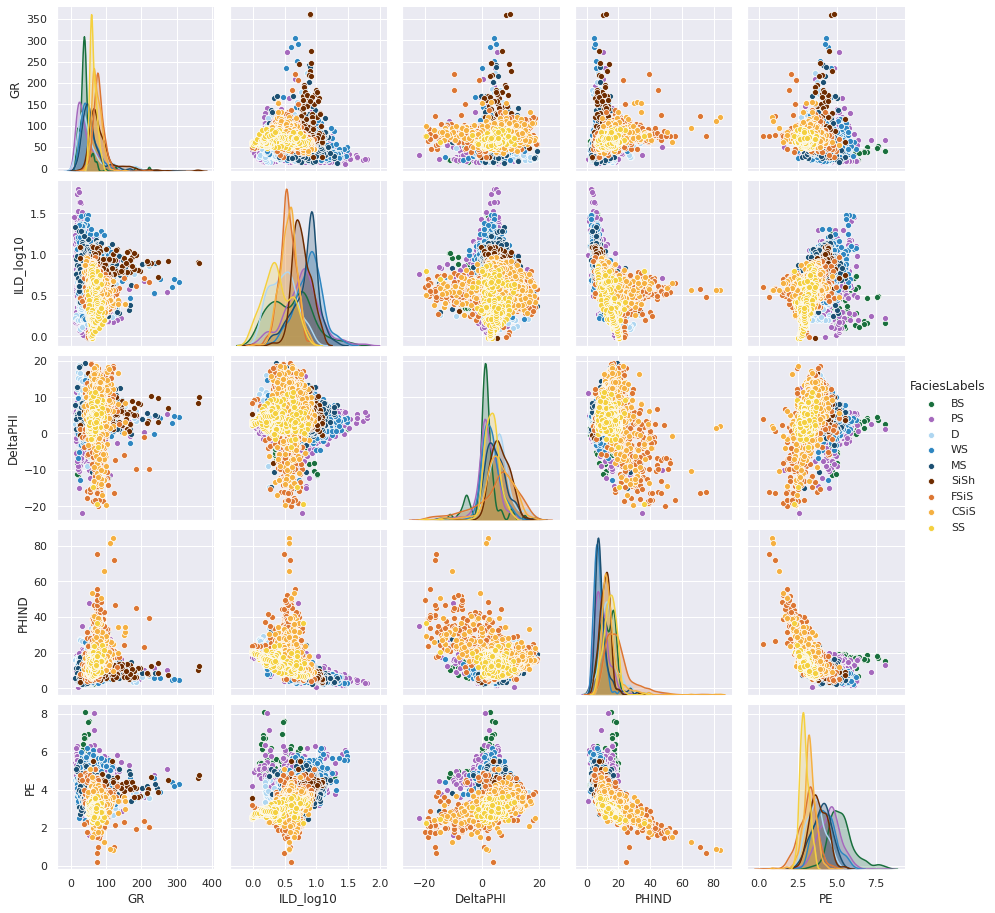

In [13]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

# 2. Data Preprocessing

In [14]:
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
X_train_full = training_data[feature_names].values
y_train_full = training_data['Facies'].values

X_test = test_data[feature_names].values
y_test = test_data['Facies'].values

## 2.1. Handling missing data

In [15]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_train_full = imputer.fit_transform(X_train_full)
X_test = imputer.transform(X_test)

## 2.2. Feature augmentation

Our guess is that facies do not abrutly change from a given depth layer to the next one. Therefore, we consider features at neighboring layers to be somehow correlated. To possibly exploit this fact, let us perform feature augmentation by:

* Aggregating features at neighboring depths.
* Computing feature spatial gradient.

from [Paolo Bestagini's routine](https://github.com/seg/2016-ml-contest/blob/master/ispl/facies_classification_try02.ipynb)

In [16]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug


# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad


# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)   
    
    return X_aug

In [17]:
X_train_full = augment_features(X_train_full, training_data['Well Name'].values, training_data['Depth'].values)
X_test = augment_features(X_test, test_data['Well Name'].values, test_data['Depth'].values)

## 2.3. Scaling

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

# 3. Manual Search

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full)

In [20]:
value, count = np.unique(y_train, return_counts=True)
list(zip(value, count/len(y_train)))

[(0, 0.06447725218439289),
 (1, 0.22657426935824043),
 (2, 0.18800843627598673),
 (3, 0.0653811388972582),
 (4, 0.07140705031636035),
 (5, 0.14010244049412474),
 (6, 0.03404639951792709),
 (7, 0.16541126845435372),
 (8, 0.04459174450135583)]

In [21]:
value, count = np.unique(y_val, return_counts=True)
list(zip(value, count/len(y_val)))

[(0, 0.06506024096385542),
 (1, 0.22650602409638554),
 (2, 0.18795180722891566),
 (3, 0.06506024096385542),
 (4, 0.07108433734939759),
 (5, 0.14096385542168674),
 (6, 0.033734939759036145),
 (7, 0.1650602409638554),
 (8, 0.04457831325301205)]

In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.metrics import accuracy_score

rnd_clf = RandomForestClassifier(n_estimators=300, min_samples_leaf=3, random_state=10)
gbt_clf = GradientBoostingClassifier(n_estimators=300, random_state=10)
svm_clf = SVC(kernel='rbf', C=1000, random_state=10)
lgb_clf = lgb.LGBMClassifier(boosting_type='gbrt', objective='multiclass', metric='multi_logloss', num_class=9, 
                             num_leaves=100, n_estimators=300, random_state=10)

In [23]:
for clf in (rnd_clf, gbt_clf, svm_clf, lgb_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, round(accuracy_score(y_val, y_pred), 2))

RandomForestClassifier 0.75
GradientBoostingClassifier 0.74
SVC 0.69
LGBMClassifier 0.8


In [24]:
lgb_clf.fit(X_train_full, y_train_full)
y_pred = lgb_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.58125

# 4. Random Search with CV

In [25]:
MAX_EVALS = 200          # Randome search 또는 bayesian optimization의 평가 반복 횟수. 
# MAX_EVALS = 400
N_FOLDS = 5

In [26]:
# Hyperparameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(7, 45)),
    'learning_rate': list(np.logspace(np.log(0.01), np.log(0.2), base = np.exp(1), num = 1000)),
    'min_child_samples': list(range(5, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 3)),
    'scale_pos_weight': list(np.linspace(1, 1.5, 10)),
    'bagging_fraction': list(np.linspace(0.5, 1, 100))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))

In [27]:
# Create a lgb dataset
train_set = lgb.Dataset(X_train_full, label = y_train_full)

In [28]:
# Dataframe to hold cv results
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators'],
                              index = list(range(MAX_EVALS)))

In [29]:
def random_objective(params, iteration, n_folds = N_FOLDS):
    cv_results = lgb.cv(params, train_set,
                        num_boost_round = 2000, 
                        nfold = n_folds, 
                        early_stopping_rounds = 100, 
                        seed = 50)

    loss = np.min(cv_results['multi_logloss-mean'])    
    n_estimators = int(np.argmin(cv_results['multi_logloss-mean']) + 1)

    return [loss, params, iteration, n_estimators]

In [30]:
import random
random.seed(10)
# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    print('#{}/{}:'.format(i+1, MAX_EVALS), end='')
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    params['objective'] = 'multiclass'
    params['metric'] = 'multi_logloss'
    params['num_class'] = 9
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]       
        
    results_list = random_objective(params, i)    
    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list
    print(' cv mean loss - {0:.2f}'.format(results_list[0]))


#1/200: cv mean loss - 0.62
#2/200: cv mean loss - 0.69
#3/200: cv mean loss - 0.74
#4/200: cv mean loss - 0.87
#5/200: cv mean loss - 0.65
#6/200: cv mean loss - 1.00
#7/200: cv mean loss - 0.74
#8/200: cv mean loss - 0.87
#9/200: cv mean loss - 0.69
#10/200: cv mean loss - 0.68
#11/200: cv mean loss - 0.74
#12/200: cv mean loss - 0.68
#13/200: cv mean loss - 0.64
#14/200: cv mean loss - 0.67
#15/200: cv mean loss - 0.87
#16/200: cv mean loss - 0.63
#17/200: cv mean loss - 0.83
#18/200: cv mean loss - 0.81
#19/200: cv mean loss - 0.67
#20/200: cv mean loss - 0.92
#21/200: cv mean loss - 0.64
#22/200: cv mean loss - 0.80
#23/200: cv mean loss - 0.66
#24/200: cv mean loss - 0.87
#25/200: cv mean loss - 0.66
#26/200: cv mean loss - 0.92
#27/200: cv mean loss - 0.63
#28/200: cv mean loss - 0.71
#29/200: cv mean loss - 0.68
#30/200: cv mean loss - 0.97
#31/200: cv mean loss - 0.75
#32/200: cv mean loss - 0.68
#33/200: cv mean loss - 0.64
#34/200: cv mean loss - 0.75
#35/200: cv mean loss -

In [31]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results.head()

,loss,params,iteration,estimators
0,0.595776,"{'class_weight': 'balanced', 'boosting_type': ...",163,1677
1,0.597164,"{'class_weight': None, 'boosting_type': 'dart'...",157,2000
2,0.598453,"{'class_weight': 'balanced', 'boosting_type': ...",36,319
3,0.603912,"{'class_weight': None, 'boosting_type': 'dart'...",115,1998
4,0.604424,"{'class_weight': None, 'boosting_type': 'gbdt'...",118,87


In [32]:
# Find the best parameters and number of estimators
best_random_params = random_results.loc[0, 'params'].copy()
best_random_estimators = int(random_results.loc[0, 'estimators'])
best_random_model = lgb.LGBMClassifier(n_estimators=best_random_estimators, n_jobs = -1, 
                                        **best_random_params, random_state = 50)

# Fit on the training data
best_random_model.fit(X_train_full, y_train_full)

LGBMClassifier(bagging_fraction=0.9292929292929293, boosting_type='dart',
               class_weight='balanced', colsample_bytree=0.6,
               learning_rate=0.042947067164006966, metric='multi_logloss',
               min_child_samples=10, n_estimators=1677, num_class=9,
               num_leaves=30, objective='multiclass', random_state=50,
               reg_alpha=0.7346938775510203, reg_lambda=0.36734693877551017,
               scale_pos_weight=1.4444444444444444,
               subsample=0.6717171717171717)

In [33]:
y_pred = best_random_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.5875

# 5. Bayesian Optimization with CV

In [34]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

In [35]:
# Define the search space
param_space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
    
    'num_leaves': hp.quniform('num_leaves', 7, 1000, 1),    
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 5, 500, 5),
    
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 1.5),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.0, 1.0),
}

In [36]:
def objective(params, n_folds = N_FOLDS):
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    params['objective'] = 'multiclass'
    params['metric'] = 'multi_logloss'
    params['num_class'] = 9    
    
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
 
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 2000, nfold = n_folds, 
                        early_stopping_rounds = 100, seed = 50)
    
    # Extract the minimum loss
    loss = np.min(cv_results['multi_logloss-mean'])
        
    n_estimators = int(np.argmin(cv_results['multi_logloss-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 'status': STATUS_OK}

In [37]:
from hyperopt import tpe

# optimization algorithm - tpe(tree of parzen estimator)
tpe_algorithm = tpe.suggest

In [38]:
from hyperopt import Trials

# Keep track of results
bayes_trials = Trials()

In [39]:
# File to save first results
out_file = './gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators'])
of_connection.close()

In [40]:
from hyperopt import fmin

In [60]:
global  ITERATION
ITERATION = 0
# Run optimization
best = fmin(fn = objective, space = param_space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

In [119]:
results = pd.read_csv('./gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head(10)

,loss,params,iteration,estimators
0,0.589078,"{'bagging_fraction': 0.1271696444405025, 'boos...",72,757
1,0.590327,"{'bagging_fraction': 0.25668588565961326, 'boo...",74,1117
2,0.591759,"{'bagging_fraction': 0.0494023244225609, 'boos...",69,212
3,0.591830,"{'bagging_fraction': 0.049945377811085906, 'bo...",70,205
4,0.591941,"{'bagging_fraction': 0.045464711661924964, 'bo...",71,307
5,0.594371,"{'bagging_fraction': 0.10769724116333668, 'boo...",90,2000
6,0.594946,"{'bagging_fraction': 0.07644981546731926, 'boo...",58,219
7,0.597769,"{'bagging_fraction': 0.24528394650632251, 'boo...",79,720
8,0.598884,"{'bagging_fraction': 0.00025460071733082734, '...",99,367
9,0.599025,"{'bagging_fraction': 0.09643219238116357, 'boo...",66,334


In [112]:
# Extract the ideal number of estimators and hyperparameters
import ast
index = 0
best_bayes_estimators = int(results.loc[index, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[index, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       random_state = 50, **best_bayes_params)
best_bayes_model.fit(X_train_full, y_train_full)

LGBMClassifier(bagging_fraction=0.1271696444405025, boosting_type='dart',
               colsample_bytree=0.6247637134332326,
               learning_rate=0.06979904413902437, metric='multi_logloss',
               min_child_samples=15, n_estimators=757, num_class=9,
               num_leaves=456, objective='multiclass', random_state=50,
               reg_alpha=0.3923340106558623, reg_lambda=0.41161637123970096,
               scale_pos_weight=1.1756060348966444,
               subsample=0.7149443904937924, subsample_for_bin=140000)

In [115]:
y_pred = best_bayes_model.predict(X_test)

In [116]:
accuracy_score(y_pred, y_test)

0.59

# 6. Hyperopt-Sklearn

<img src="hyperopt.png">

image from *Komer, B., Bergstra, J., & Eliasmith, C. (2019). Hyperopt-Sklearn. In Automated Machine Learning (pp. 97-111). Springer, Cham.*

In [61]:
from hpsklearn import HyperoptEstimator, any_classifier, any_preprocessing
from hyperopt import tpe

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [ ]:
estim = HyperoptEstimator(classifier=any_classifier('my_clf'),
                          preprocessing=any_preprocessing('my_pre'),
                          algo=tpe.suggest,
                          max_evals=MAX_EVALS,
                          trial_timeout=1000)

# Search the hyperparameter space based on the data
estim.fit(X_train_full, y_train_full)

 90%|██████████████████████████████████████████████████████████████       | 9/10 [00:00<?, ?trial/s, best loss=?]

In [ ]:
estim.best_model()

In [ ]:
estim.retrain_best_model_on_full_data(X_train_full, y_train_full)

In [ ]:
estim.score(X_test, y_test)